Book 3

In [1]:
import sys
print(sys.executable)

/media/HHD_2TB/baurai/aditya_vm/bin/python3.6


In [2]:
import os
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from functools import partial
import tensorflow as tf
%load_ext tensorboard

print("Python version used = ", sys.version)
print("Numpy version = ", np.__version__)
print("Tensorflow version = ", tf.__version__)

Python version used =  3.6.9 (default, Oct  9 2020, 08:58:16) 
[GCC 6.3.0 20170516]
Numpy version =  1.18.5
Tensorflow version =  2.3.1


In [3]:
config = {
    "IMAGE_SIZE" : (512, 512),
    "AUTOTUNE" : tf.data.experimental.AUTOTUNE,
    "BATCH_SIZE" : 64,
    "EPOCHS" : 25
}

# TFRec Metadata Exploration

In [4]:
metadata = pd.DataFrame(pd.read_csv("tfrec_v2/metadata_bin_clf_tfrec.csv"))

print("Shape = ", metadata.shape)

Shape =  (79988, 3)


In [5]:
metadata.head()

,image_name,label,subset
0,00012907_003.png,0,training
1,00014264_002.png,0,training
2,00001650_007.png,0,training
3,00013894_000_0.png,1,training
4,00013894_000_1.png,1,training


## Training

In [6]:
train = metadata[metadata["subset"] == "training"]

print("Training data shape = ", train.shape)

Training data shape =  (59980, 3)


In [7]:
healthy_cases = len(train[train["label"] == 0])
nodular_cases = len(train[train["label"] == 1])

print("Healthy cases in training set = ", healthy_cases)
print("Nodular cases in training set = ", nodular_cases)

Healthy cases in training set =  42252
Nodular cases in training set =  17728


## Validation

In [8]:
val = metadata[metadata["subset"] == "validation"]

print("Validation data shape = ", val.shape)

Validation data shape =  (10004, 3)


In [9]:
healthy_cases = len(val[val["label"] == 0])
nodular_cases = len(val[val["label"] == 1])

print("Healthy cases in validation set = ", healthy_cases)
print("Nodular cases in validation set = ", nodular_cases)

Healthy cases in validation set =  9054
Nodular cases in validation set =  950


## Testing

In [10]:
test = metadata[metadata["subset"] == "testing"]

print("Testing data shape = ", test.shape)

Testing data shape =  (10004, 3)


In [11]:
healthy_cases = len(test[test["label"] == 0])
nodular_cases = len(test[test["label"] == 1])

print("Healthy cases in testing set = ", healthy_cases)
print("Nodular cases in testing set = ", nodular_cases)

Healthy cases in testing set =  9055
Nodular cases in testing set =  949


# TFRec Loading

In [13]:
training_filenames = tf.io.gfile.glob("tfrec_v2/train*.tfrec")
#validation_filenames = tf.io.gfile.glob("tfrec_new/val*.tfrec")
#testing_filenames = tf.io.gfile.glob("tfrec_new/test*.tfrec")

print("Number of training TFRec files = ", len(training_filenames))
#print("Number of validation TFRec files = ", len(validation_filenames))
#print("Number of testing TFRec files = ", len(testing_filenames))

Number of training TFRec files =  94


# Define The Loading Pipeline : 

* Call **load_dataset** function : This function is called with validation/training/testing filenames. In case the dataset is unlabeled, simply pass False parameter to it, along with a choice whether you want to load things in order or not. Normally, **we disable it for boosting our computation speed**. This load_training dataset will return our dataset(a pair of **(image, label) if labeled = True** was passed, otherwise **(image, image_name))**. How it does that, will be seen ahead in the notebook.
* Now, we have images wih us, in the dataset. We will define and call image_augmentation method to apply some transformation to these images, before we use them further.
* Once it is done, we call the repeat function which repeats this dataset so each original value is seen count times. The default behavior (if count is None or -1) is for the dataset be repeated indefinitely.
* Shuffling - The shuffle( ) function randomly shuffles the elements of this dataset.Internally, the dataset fills a buffer with buffer_size elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required. *For instance, if your dataset contains 10,000 elements but buffer_size is set to 1,000, then shuffle will initially select a random element from only the first 1,000 elements in the buffer. Once an element is selected, its space in the buffer is replaced by the next (i.e. 1,001-st) element, maintaining the 1,000 element buffer*.
* Group the images into batches.
* **Prefetch( )** : Most dataset input pipelines should end with a call to prefetch. **This allows later elements to be prepared while the current element is being processed. This often improves latency and throughput, at the cost of using additional memory to store prefetched elements**.
* **cache( )** : The first time the dataset is iterated over, its elements will be cached either in the specified file or in memory. Subsequent iterations will use the cached data. When caching to a file, the cached data will persist across runs. Even the first iteration through the data will read from the cache file.

In [14]:
def get_training_dataset() : 
    dataset = load_dataset(training_filenames, labeled = True, ordered = False)
    dataset = dataset.map(image_augmentation, num_parallel_calls = config["AUTOTUNE"])
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(config["BATCH_SIZE"])
    dataset = dataset.prefetch(config["AUTOTUNE"])
    return dataset

In [15]:
def get_validation_dataset() :
    dataset = load_dataset(validation_filenames, labeled = True, ordered = True)
    dataset = dataset.map(image_augmentation, num_parallel_calls = config["AUTOTUNE"])
    dataset = dataset.batch(config["BATCH_SIZE"])
    dataset = dataset.cache()
    dataset = dataset.prefetch(config["AUTOTUNE"])
    return dataset

In [16]:
def get_testing_dataset() : 
    dataset = load_dataset(testing_filenames, labeled = True, ordered = True)
    dataset = dataset.map(image_augmentation, num_parallel_calls = config["AUTOTUNE"])
    dataset = dataset.batch(config["BATCH_SIZE"])
    dataset = dataset.cache()
    dataset = dataset.prefetch(config["AUTOTUNE"])
    return dataset

# Structuring Functions :
These functions will help in overall structuring of the pipeline.

Setting default value of :

* **ordered as False** - For high performance we will be reading data from multiple file sources at once, and the dataset will be shuffled before reading commences.

* **labeled as true** - Can set it to False too, doesn't matter much. Or, simply leave it be.

*Role of partial( ) functools :*

Treat this as an operation which results in a object(called partial object). **These objects when invoked, behave like functions with positional/additional(but not mandatory) arguments**.

So, sometimes we may have labels, hence the function call will be initated using labeled = True. Sometimes, we won't. In that case, function calls will be initiated with a False initialization of the labeled argument.

In [17]:
def load_dataset(filenames, labeled = True, ordered = False):
    ignore_order = tf.data.Options()
    if ordered == False : 
        ignore_order.experimental_deterministic = False # disable order
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = config["AUTOTUNE"])
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(partial(read_tfrecord, labeled = labeled), num_parallel_calls = config["AUTOTUNE"])
    return dataset

According to feature mapping present in our TFRecord files, we design the following functions.

In [18]:
def read_tfrecord(example, labeled) : 
    if labeled == True : 
        tfrecord_format = {
            "image" : tf.io.FixedLenFeature([], tf.string),
            "label" : tf.io.FixedLenFeature([], tf.int64)
        }
    else:
        tfrecord_format = {
            "image" : tf.io.FixedLenFeature([], tf.string),
            "image_name" : tf.io.FixedLenFeature([], tf.string)
        }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example["image"])
    
    if labeled == True : 
        label = tf.cast(example["label"], tf.int32)
        return image, label
    else:
        image_name = example["image_name"]
        return image, image_name

In [19]:
def decode_image(image) : 
    image = tf.image.decode_jpeg(image, channels = 3) # decode JPEG-encoded image to uint8 tensor
    image = tf.cast(image, tf.float32) 
    image = image/255.0 
    image = tf.reshape(image, [config["IMAGE_SIZE"][0], config["IMAGE_SIZE"][1], 3]) # reshapes tensor structure
    return image

In [20]:
def image_augmentation(image, label) : 
    image = tf.image.resize(image, [config["IMAGE_SIZE"][0], config["IMAGE_SIZE"][1]])
    image = tf.image.random_flip_left_right(image)
    return image, label

In [21]:
def batch_to_numpy(batch_data) : 
    images, labels = batch_data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object : 
        numpy_labels = [None for _ in enumerate(numpy_images)] # image_name is there. Not label.
    return numpy_images, numpy_labels

In [22]:
label_dict = {
    0 : "Healthy",
    1 : "Nodular"
}

def display_batch(batch_data, predictions = None) : 
    images, labels = batch_to_numpy(batch_data)
    if all(labels == None) : 
        labels = [None for _ in enumerate(images)]
    
    rows = int(math.sqrt(len(images)))
    columns = len(images)//rows
    
    plt.figure(figsize = (20, 20))
    for n in range(len(images)) : 
        ax = plt.subplot(rows, columns, n + 1)
        plt.imshow(images[n])
        if labels[n] is not None : 
            plt.title(label_dict[labels[n]], fontsize = 16)
    plt.grid(False)
    plt.tight_layout()

# Get Datasets

In [23]:
training_dataset = get_training_dataset()
#validation_dataset = get_validation_dataset()
#testing_dataset = get_testing_dataset()

print("Training dataset |||| ", training_dataset)
#print("Validation dataset |||| ", validation_dataset)
#print("Testing dataset |||| ", testing_dataset)

Training dataset ||||  <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int32)>


In [24]:
STEPS_PER_EPOCH_TRAIN = len(train)// config["BATCH_SIZE"]
#STEPS_PER_EPOCH_VAL = len(val)// config["BATCH_SIZE"]

print("Steps per epoch TRAIN = ", STEPS_PER_EPOCH_TRAIN)
#print("Steps per epoch VAL = ", STEPS_PER_EPOCH_VAL)

Steps per epoch TRAIN =  937


In [25]:
training_iter = iter(training_dataset.unbatch().batch(16))
print(training_iter)

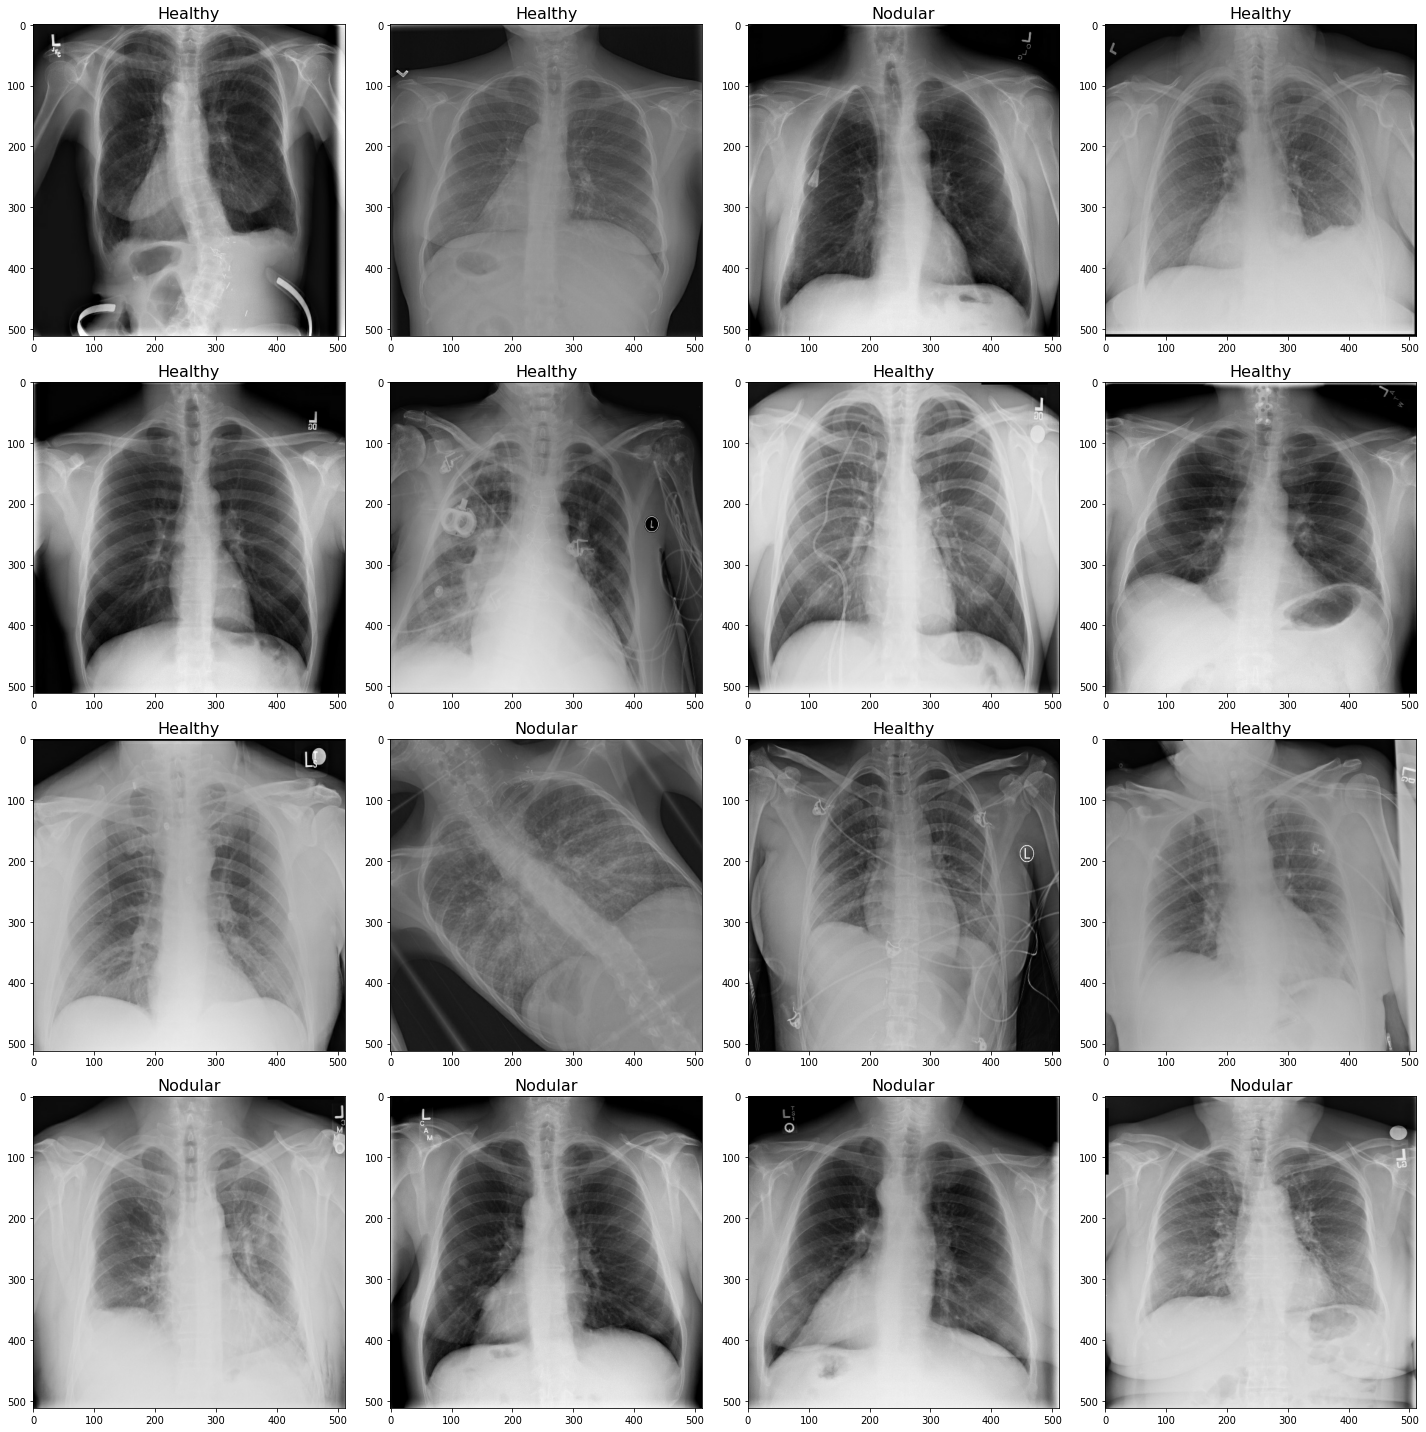

In [26]:
display_batch(next(training_iter))

In [27]:
del training_iter

# Model Construction : 

In [28]:
gpus = tf.config.list_physical_devices("GPU")
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [29]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
tf.config.optimizer.set_experimental_options({"auto_mixed_precision" : True})
print("Mixed precision available")

Mixed precision available


Setting up Tensorboard's Log Root Directory.

In [30]:
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir() : 
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

## Callbacks

In [31]:
callback_early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "auc", patience = 8, verbose = 1, restore_best_weights = True)
callback_lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor = "auc", factor = 0.1, patience = 3, verbose = 1, min_lr = 1e-5)
callback_tensorboard = tf.keras.callbacks.TensorBoard(run_logdir)

## Class Weight Initialization

In [38]:
train = metadata[metadata["subset"] == "training"]
healthy_cases = len(train[train["label"] == 0])
nodular_cases = len(train[train["label"] == 1])
total_cases = healthy_cases + nodular_cases

weight_healthy = (total_cases/healthy_cases)/2.0
weight_nodular = (total_cases/nodular_cases)/2.0


class_weight = {0 : weight_healthy , 1 : weight_nodular}

print("Weight for healthy cases = ", class_weight[0])
print("Weight for nodular cases = ", class_weight[1])

Weight for healthy cases =  0.7097888857332197
Weight for nodular cases =  1.6916741877256318


In [39]:
def build_model(input_shape) : 
    input_tensor = tf.keras.layers.Input(shape = input_shape, name = "input_layer")
    
    base_model = tf.keras.applications.ResNet50V2(include_top = False, weights = "imagenet", input_tensor = input_tensor, pooling = "avg")
    base_model.trainable = False
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.BatchNormalization(),
                
        tf.keras.layers.Dense(units = 256, activation = tf.keras.layers.PReLU(), kernel_initializer="he_normal"),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Dense(units = 256, activation = tf.keras.layers.PReLU(), kernel_initializer="he_normal"),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Dense(units = 128, activation = tf.keras.layers.PReLU(), kernel_initializer="he_normal"),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Dense(units = 128, activation = tf.keras.layers.PReLU(), kernel_initializer="he_normal"),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Dense(units = 60, activation = tf.keras.layers.PReLU(), kernel_initializer="he_normal"),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Dense(units = 30, activation = tf.keras.layers.PReLU(), kernel_initializer="he_normal"),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Dense(units = 10, activation = tf.keras.layers.PReLU(), kernel_initializer="he_normal"),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Dense(units = 1, activation = "sigmoid")
        
    ])
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-1), loss = tf.keras.losses.BinaryCrossentropy(), 
                  metrics = [tf.keras.metrics.AUC(name = "auc")])
    return model

In [41]:
input_shape = (config["IMAGE_SIZE"][0], config["IMAGE_SIZE"][1], 3)
with tf.device("/device:GPU:0"):
    model = build_model(input_shape)
    print(model.summary())
    print("\nInput Analysis = ", model.input)
    print("\nOutput Analysis = ", model.output)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
batch_normalization_8 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_8 (Dense)              (None, 256)               524800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 256)               1024      
_________________________________________________________________
dense_9 (Dense)              (None, 256)               66048     
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)              

In [42]:
def model_layer_analysis(model) : 
    pd.set_option("max_colwidth", None)
    info = [(layer.name, layer.trainable, layer) for layer in model.layers]
    analysis = pd.DataFrame(info, columns = ["Layer Name", "Train Status", "Layer Type"])
    return analysis

Perform model analysis

In [43]:
analysis = model_layer_analysis(model)
analysis

,Layer Name,Train Status,Layer Type
0,resnet50v2,False,<tensorflow.python.keras.engine.functional.Functional object at 0x7f89382d7080>
1,batch_normalization_8,True,<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f89382d7c50>
2,dense_8,True,<tensorflow.python.keras.layers.core.Dense object at 0x7f893829e7f0>
3,dropout_7,True,<tensorflow.python.keras.layers.core.Dropout object at 0x7f893829ea20>
4,batch_normalization_9,True,<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f893829eb70>
5,dense_9,True,<tensorflow.python.keras.layers.core.Dense object at 0x7f893829eeb8>
6,dropout_8,True,<tensorflow.python.keras.layers.core.Dropout object at 0x7f8938298128>
7,batch_normalization_10,True,<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f8938298278>
8,dense_10,True,<tensorflow.python.keras.layers.core.Dense object at 0x7f89382985c0>
9,dropout_9,True,<tensorflow.python.keras.layers.core.Dropout object at 0x7f89382987b8>


In [44]:
with tf.device("/device:GPU:0") : 
    history = model.fit(training_dataset, epochs = config["EPOCHS"], steps_per_epoch = STEPS_PER_EPOCH_TRAIN,
                       callbacks = [callback_early_stopping, callback_lr_reduce, callback_tensorboard],
                       class_weight = class_weight)

Epoch 1/25
  1/937 [..............................] - ETA: 0s - loss: 0.9833 - auc: 0.4605WARNING:tensorflow:From /media/HHD_2TB/baurai/aditya_vm/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
937/937 [==============================] - 176s 187ms/step - loss: 0.5617 - auc: 0.7475
Epoch 2/25
937/937 [==============================] - 176s 188ms/step - loss: 0.5171 - auc: 0.8020
Epoch 3/25
937/937 [==============================] - 176s 188ms/step - loss: 0.5035 - auc: 0.8147
Epoch 4/25
937/937 [==============================] - ETA: 0s - loss: 0.4990 - auc: 0.8200
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
937/937 [==============================] - 176s 188ms/step - loss: 0.4990 - auc: 0.8200
Epoch 5/25
937/937 [==============================] - 177s 189ms/st

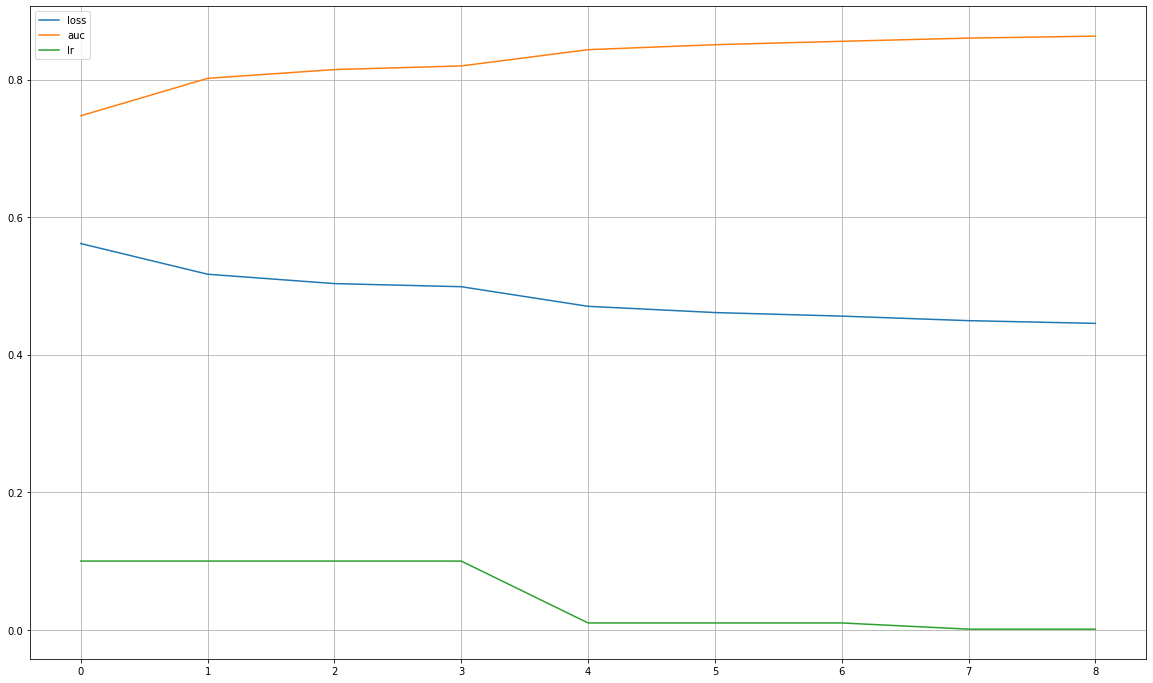

In [45]:
pd.DataFrame(history.history).plot(figsize = (20, 12))
plt.grid(True)

# Save The Model

In [ ]:
model.save('saved_models/bin_clf/resnet50v2_model')